# Linear Instability Analysis of profiles like those used in Ramachandran et al 2014 

RTM14 considered an interesting problem of a coupled mixed layer/deep front. 
The problem varied two things
- the depth of the front/ depth upto which shear or horizontal b gradient extends.
- the stratification at the base of the mixed layer

Here we want to do a linear stability analysis on the profiles that were used as initial conditions in the model, to see how the strength of the stratification at the base of the mixed layer impacts the instability growth rates. 

Ref: The analysis here is based on a set of notes  "mli_stir.pdf" titled "Stirring by MLI and Charney-type BCI" shared by Shafer.

----

We will work with profiles that are homogeneous in the horizontal direction, and only vary in z. The z-coordinate is 0 at the surface and becomes negative at depth. 

We define a N2 profile as 

$$
N^2(z) = \alpha + \beta \tanh({\frac{z - H_{ml}}{d}}) + \gamma sech^2 ({\frac{z - H_{ml}}{d}})
$$
where $H_{ml} <0 $ is the z value corresponding to mixed layer base.

There are three parameters that are associated with 
- the stratification in the mixed layer: $N^2_{ML} = \alpha + \beta $
- the stratification in the thermocline: $N^2_{TC} = \alpha - \beta $. (assumed to be a constant here)
- the stratification in the transition layer: $N^2_{TR} = \alpha + \gamma$. 


We define a shear profile as

$$
u_z (z) = A (tanh (\frac{z - H_{shear}}{d_{shear}} ) + 1)
$$
where $H_{shear}$ is the depth to which we want to extend the shear (linear) and $d_{shear}$ is the depth over which we want the linear shear to decay to 0.

The horizontal buoyancy gradient is $b_y = -f u_z$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from oceanmodes import baroclinic

In [5]:
z = np.linspace(-0.5, -500, 100)

We set the parameters based on the Ramachandran et al 2014 study. 

In [98]:
def calc_instability_props(z, NsqrML, NsqrTC, NsqrTR, H_ml, d, f0,
                          b_y, H_shear, d_shear,):
    # make N2 profile
    alpha = 0.5*(NsqrML + NsqrTC)
    beta  = 0.5*(NsqrML - NsqrTC) 
    gamma = NsqrTR - alpha
    
    Nsqr = alpha *np.ones_like(z) + beta *np.tanh( (z - H_ml)/d ) + gamma / (np.cosh( (z - H_ml)/d )**2)
    
    # make u_z and u profile
    dUdz = b_y/f0*(np.tanh( (z - H_shear)/d_shear ) + 1)/2
    U = np.cumsum(dUdz)* (z[1]-z[0])
    U = U + np.abs( np.min(U))
    
    # calc first 6 modes
    #zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(
    #-z, Nsqr, f0)
    
    # calc instability rates
    
    kmin = 2*np.pi/1000e3
    kmax = 2*np.pi/100
    k = np.logspace( np.log10(kmin), np.log10(kmax), 50)

    #k= np.logspace(-4, 0,100)/1000.
    l =np.array([0.])

    etax = np.zeros(2)
    etay = np.zeros(2)
    
    zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile(-z[0:-1], Nsqr[0:-1], f0, 0, 
                                                              k,l, -z, U , 0*U, 
                                                               etax, etay,
                                                              Ah=0, num=2)
    
    return {'k':k, 'gr': w.imag[0], 'z':z,'N2': Nsqr,'U': U, 'U_z':dUdz}

In [99]:
H_ml = -100 
d= 10 # this parameter was not in the study but allows smoothness
f0 = 1e-4

NsqrML = 1e-6
NsqrTC = 1e-5
NsqrTR = 1e-4

H_shear = -100 
d_shear = 5
b_y = 0.9e-7

# case nb
nb_props = calc_instability_props(z, NsqrML, NsqrTC, NsqrTR, H_ml, d, f0,
                          b_y, H_shear, d_shear)

# case b1 
H_shear = -300 
d_shear = 75
b_y = 0.9e-7

b1_props = calc_instability_props(z, NsqrML, NsqrTC, NsqrTR, H_ml, d, f0,
                          b_y, H_shear, d_shear)

# case b1_star 
NsqrTC = 3e-5
H_shear = -300 
d_shear = 75
b_y = 0.9e-7

b1star_props = calc_instability_props(z, NsqrML, NsqrTC, NsqrTR, H_ml, d, f0,
                          b_y, H_shear, d_shear)

# case b4
NsqrTC =1e-5
NsqrTR = 3.4e-4
H_shear = -300 
d_shear = 75
b_y = 0.9e-7

b4_props = calc_instability_props(z, NsqrML, NsqrTC, NsqrTR, H_ml, d, f0,
                          b_y, H_shear, d_shear)

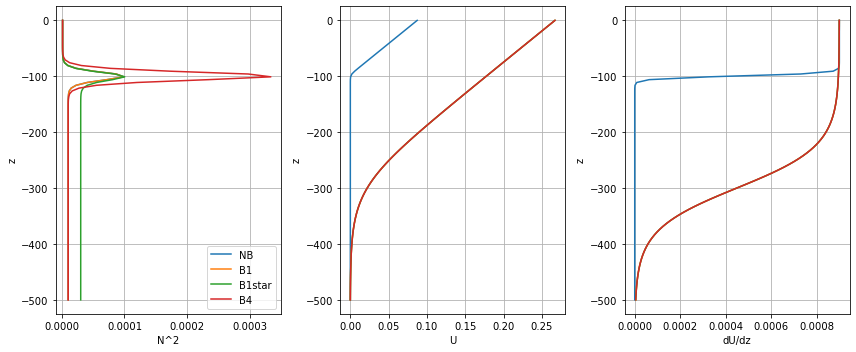

In [102]:
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.plot(nb_props['N2'], nb_props['z'], label='NB')
plt.plot(b1_props['N2'], b1_props['z'], label='B1')
plt.plot(b1star_props['N2'], b1star_props['z'], label='B1star')
plt.plot(b4_props['N2'], b4_props['z'], label='B4')
plt.grid()
plt.legend()
plt.xlabel('N^2')
plt.ylabel('z')
plt.xlim([-1e-5, 3.5e-4])

plt.subplot(132)
plt.plot(nb_props['U'], nb_props['z'], label='NB')
plt.plot(b1_props['U'], b1_props['z'], label='B1')
plt.plot(b1star_props['U'], b1star_props['z'], label='B1star')
plt.plot(b4_props['U'], b4_props['z'], label='B4')
plt.grid()
plt.xlabel('U')
plt.ylabel('z')

plt.subplot(133)
plt.plot(nb_props['U_z'], nb_props['z'], label='NB')
plt.plot(b1_props['U_z'], b1_props['z'], label='B1')
plt.plot(b1star_props['U_z'], b1star_props['z'], label='B1star')
plt.plot(b4_props['U_z'], b4_props['z'], label='B4')
plt.grid()
plt.xlabel('dU/dz')
plt.ylabel('z')
#plt.xlim([-1e-5, 3.5e-4])

plt.tight_layout()

We study a few different profiles. 
- NB has shear (or horizontal buoyancy gradients) only in the mixed layer.
- B1, B1star, B4 have shear that extends below the mixed layer.
- B1 abd B1 star differ in the stratification in the thermocline, with B1star being more stratified in the interior.
- B4 is the same as B1 but has stronger stratification at the base of the mixed layer.

Text(0, 0.5, 'Growth rate/f (1/inertial period)')

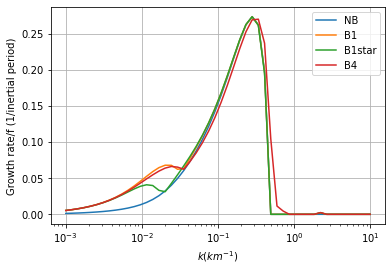

In [112]:
plt.plot(nb_props['k']*1000./np.pi/2, nb_props['gr'].T/f0, label='NB')
plt.plot(b1_props['k']*1000./np.pi/2, b1_props['gr'].T/f0, label='B1')
plt.plot(b1star_props['k']*1000./np.pi/2, b1star_props['gr'].T/f0, label='B1star')
plt.plot(b4_props['k']*1000./np.pi/2, b4_props['gr'].T/f0, label='B4')
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel(r'$k (km^{-1})$')
plt.ylabel('Growth rate/f (1/inertial period)')

The observed instability scales can be understood according to the Eady instability problem.

The Eady instability scale is
$$
L = 3.9NH/f
$$
and growth rate is 
$$
\sigma = 0.3f|dU/dz|/N
$$


**The observed instability scales are broadly in agreement. As calcl below.**

In the above figure there are two peaks: 
The peak corresponding to the **mixed layer** is near $L = 3.9*1e-3 * 100/1e-4 = 3900m$, which is same order of magnitude as where we se the peak (~3-5km). The growth rate is $\sigma/f = 0.3*(0.9e-7/1e-4)/1e-3 = 0.27$, which matches quite well with the growth rate or 4 inertial periods. 

The peak corresponding to the **thermocline** is near $L = 3.9*(1e-5)^{0.5} * 500/1e-4 = 62.4km$, which is same order of magnitude as where we se the peak (~50km). The growth rate is $\sigma/f = 0.3*0.9e-7/(1e-5)^{0.5} = 0.085$, which matches quite well with the observed growth time of 14 inertial periods. 

**Note**
* that $B1*$ case considered has a growth rate of 25 days, which is very close to the 31 days when the Ramachandran et al 2014 study stopped their studies. We considered $B1*$ because it is not clear from the paper what the $N^2$ is in their studies is (Their fig 2b and 3 seem to suggest that N^2 might be higher in the thermocline for the B1-4 studies). It is possible that they ran their experiments for too short of a period!

* Their figure 7 suggests that in their B3 and B4 the deep instability has not kicked in even after 31 inertial periods. Why is this?? Can this be related to the stratification at the base of the ML? The linear instability analysis would suggest that all the B1-B4 experiments should evolve the same.

*The stratification at the base of the mixed layer does not enter the scalings of the instability scales!* 

However, $N^2$ structure is a big part of the omega equation:
...
